In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.OneHeadModel import OneHeadModel

import helper_functions

In [2]:
allow_train = True
load_pre_train_model = True
freeze_encoder = False
EPOCHS = 70
BATCH_SIZE = 128
shrink_size = None

lr = 1e-4
weight_deacay = 1e-5
T_max = 70
eta_min = 3e-7
num_augs = 5
p_dropout = 0.3

crop_size = 380

# weights for alpha is inverse frequency

# alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
alpha = torch.tensor([1, 1, 1, 1, 1])
gamma = 2
label_smoothing = 0.1

# alpha = [1] * 5
# alpha = [1/1805, 1/370, 1/999, 1/193, 1/295] * 500 

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms(crop_size)
no_transforms = helper_functions.get_augmentation_no_transforms(crop_size)

In [5]:
# load all dataloaders

train_dataloader, val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_train_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=test_transforms,
    shrink_size=shrink_size)

MESSIDOR_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='MESSIDOR',
    shrink_size=shrink_size)   

IDRID_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='IDRID',
    shrink_size=shrink_size) 

APTOS_15_test_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='APTOS_15_test',
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285712].


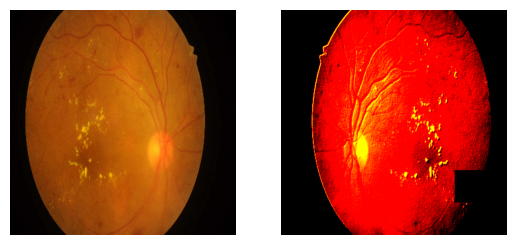

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(1):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = OneHeadModel(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
def prepare_model():
    if load_pre_train_model:
        model.load_state_dict(torch.load("models/pre_train_model.pth", weights_only=True, map_location=device))

        nn.init.kaiming_normal_(model.dense1.weight, mode='fan_in', nonlinearity='relu')
        if model.dense1.bias is not None:
            nn.init.zeros_(model.dense1.bias)

        for module in model.classification_head:
            if isinstance(module, nn.Linear):
                # Apply He initialization to weights
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                # Initialize biases to zero (optional, common practice)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
OneHeadModel (OneHeadModel)                                  [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1792, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 48, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 48, 120, 120]   1,296                True
│    │    └─BatchNorm2d (1)                                  [32, 48, 120, 120]   [32, 48, 120, 120]   96                   True
│    │    └─SiLU (2)                                         [32, 48, 120, 120]   [32, 48, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 48, 120, 120]   [32, 24, 120

Custom Focal Loss function

In [10]:
# class FocalLoss_custom(torch.nn.Module):
#     def __init__(self, alpha, gamma, headType=None):
#         super(FocalLoss_custom, self).__init__()
#         self.alpha = alpha.to(device)
#         self.gamma = gamma
#         self.headType = headType
#     def forward(self, inputs, targets):
        
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
#         # apply class weights
#         # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
#         weights = self.alpha.gather(0, targets)

#         pt = torch.exp(-ce_loss)
#         loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
#         # loss = (self.alpha * ((1 - pt) ** self.gamma) * ce_loss)
#         return loss.mean()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, label_smoothing=0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha.to(device)
        self.gamma = gamma
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [12]:
# Define loss and optimizer

# from going_modular.focal_loss import FocalLoss

# weights are selected based on the APTOS 2019 distribution according to the paper
# weight = torch.tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weight = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 

# weights.to(device)

# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weight).to(device)
# loss_fn_classification = FocalLoss_custom(headType='classification', alpha=alpha, gamma=gamma).to(device)
loss_fn_classification = FocalLoss(alpha=alpha, gamma=gamma, label_smoothing=label_smoothing).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)


First the encoder is frozen for 5 epochs...



  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1, Learning Rate: 9.994980436708454e-05
loss_classification_train: 1.6472 | loss_classification_val: 1.1862 | acc_classification_val: 0.4244

Epoch 2, Learning Rate: 9.979931855566268e-05
loss_classification_train: 1.3756 | loss_classification_val: 0.8328 | acc_classification_val: 0.6648

Epoch 3, Learning Rate: 9.954884562413155e-05
loss_classification_train: 1.0309 | loss_classification_val: 0.6571 | acc_classification_val: 0.7140

Epoch 4, Learning Rate: 9.91988899916417e-05
loss_classification_train: 0.8870 | loss_classification_val: 0.6144 | acc_classification_val: 0.7341

Epoch 5, Learning Rate: 9.875015642226391e-05
loss_classification_train: 0.7955 | loss_classification_val: 0.5351 | acc_classification_val: 0.7341

Now the encoder will be trained...



  0%|          | 0/70 [00:00<?, ?it/s]


Epoch 1, Learning Rate: 9.82035486056883e-05
loss_classification_train: 0.7163 | loss_classification_val: 0.5306 | acc_classification_val: 0.7541

Epoch 2, Learning Rate: 9.756016733731342e-05
loss_classification_train: 0.6746 | loss_classification_val: 0.4975 | acc_classification_val: 0.7413

Epoch 3, Learning Rate: 9.682130830139091e-05
loss_classification_train: 0.6428 | loss_classification_val: 0.4611 | acc_classification_val: 0.7541

Epoch 4, Learning Rate: 9.598845946168983e-05
loss_classification_train: 0.6154 | loss_classification_val: 0.4677 | acc_classification_val: 0.7559

Epoch 5, Learning Rate: 9.50632980649356e-05
loss_classification_train: 0.5804 | loss_classification_val: 0.4767 | acc_classification_val: 0.7723

Epoch 6, Learning Rate: 9.404768726305841e-05
loss_classification_train: 0.6078 | loss_classification_val: 0.4427 | acc_classification_val: 0.7778

Epoch 7, Learning Rate: 9.294367236105304e-05
loss_classification_train: 0.6398 | loss_classification_val: 0.4900

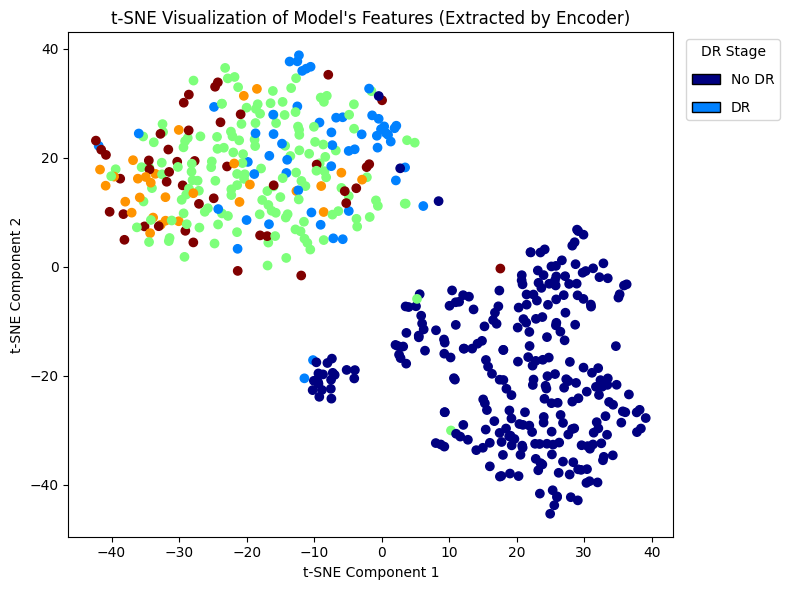

[INFO] Saving model to: models/main_train_model.pth
[INFO] Total training time: 518.098 seconds


In [13]:
model = torch.compile(model)

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results

    prepare_model() # restet model's weights to pre train for each fold

    print('\nFirst the encoder is frozen for 5 epochs...\n')

    # Freeze all base layers in the "features" section of the model 
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    # training for 5 epochs to save pre train weights
    _, _ = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=5,
                device=device)
    
    # resetting the scheduler
    # scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    print('\nNow the encoder will be trained...\n')
    
    # UnFreeze all base layers in the "features" section of the model 
    for param in model.encoder.parameters():
        param.requires_grad = True

    train_results, val_results = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=EPOCHS,
                device=device)
    
    helper_functions.plot_t_SNE(model=model,
                            dataloader=val_dataloader,
                            NUM_ITER=2000)
    
    utils.save_model(model=model, target_dir='models', model_name=f'main_train_model.pth')


    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

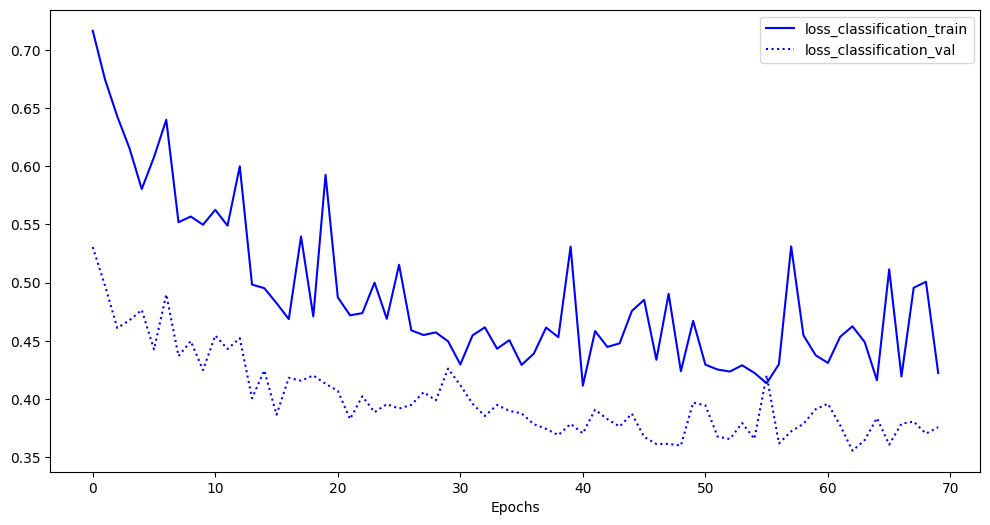

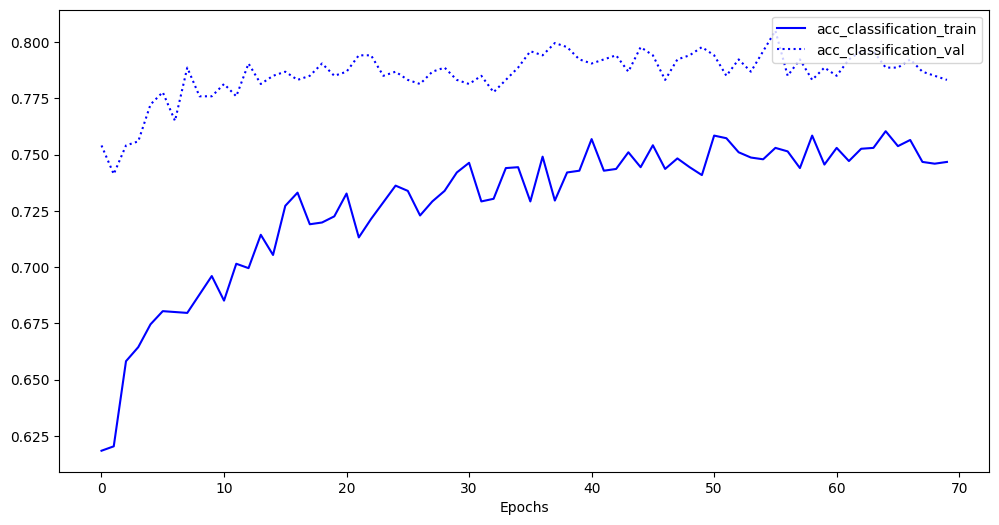

In [14]:
if allow_train:
    helper_functions.plot_loss_curves(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

per class precision: [0.96428571 0.67741935 0.61751152 0.4        0.58333333]
per class recall: [0.99630996 0.375      0.89333333 0.13793103 0.15909091]
per class f1_score: [0.9800363  0.48275862 0.73024523 0.20512821 0.25      ]
average scores >>> precision: 0.6485099846390169 | recall: 0.5123330480013264 | f1_score: 0.5296336710132287
accuracy: 0.7927272727272727
QWK:  0.8442797853754204


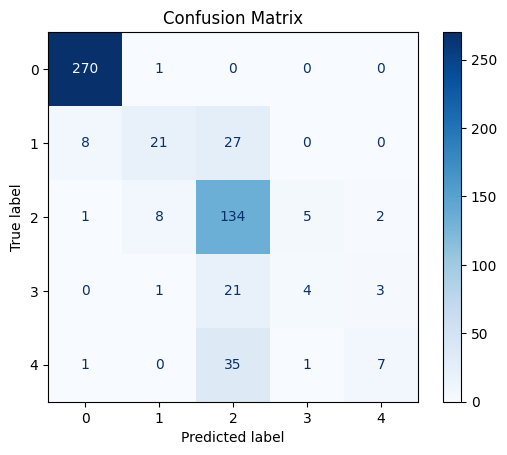

In [15]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            device=device)

per class precision: [0.98502758 0.74657534 0.6194605  0.55555556 0.53571429]
per class recall: [0.98970705 0.42084942 0.91988555 0.22222222 0.14492754]
per class f1_score: [0.98736177 0.5382716  0.74035694 0.31746032 0.22813688]
average scores >>> precision: 0.6884666530942495 | recall: 0.5395183553609078 | f1_score: 0.5623175022256572
accuracy: 0.8045259461568475
QWK:  0.8431004300743075


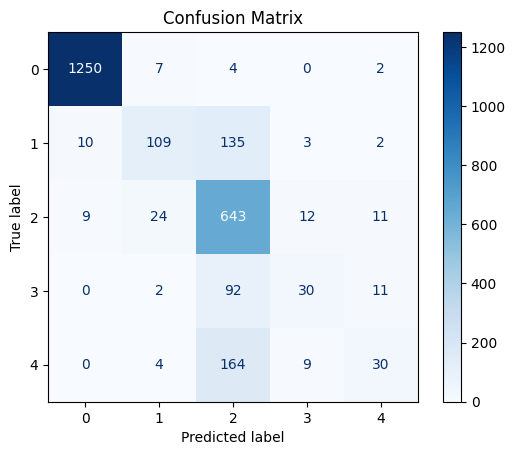

In [16]:
test_results = engine.test_step(model=model,
            dataloader=exp_train_dataloader,
            device=device)

per class precision: [0.73965388 0.1640625  0.57303371 0.         0.26315789]
per class recall: [0.96656834 0.07777778 0.44092219 0.         0.14285714]
per class f1_score: [0.83802217 0.10552764 0.49837134 0.         0.18518519]
average scores >>> precision: 0.34798159553921326 | recall: 0.3256250898172808 | f1_score: 0.32542126485378403
accuracy: 0.6662844036697247
QWK:  0.6486033314002079


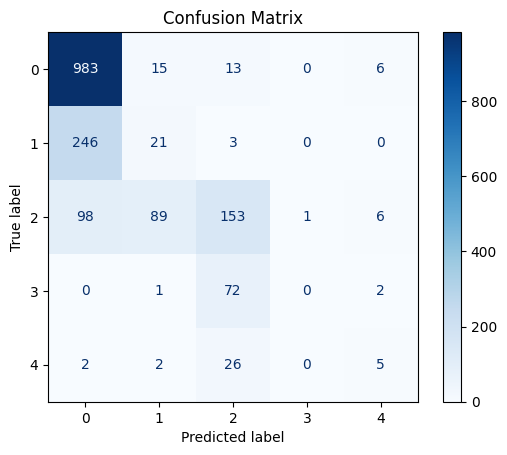

In [17]:
MESSIDOR_test_results = engine.test_step(model=model,
            dataloader=MESSIDOR_dataloader,
            device=device)

per class precision: [0.8        0.12359551 0.44827586 0.53333333 0.25      ]
per class recall: [0.86821705 0.5        0.58333333 0.0952381  0.03125   ]
per class f1_score: [0.83271375 0.1981982  0.50696379 0.16161616 0.05555556]
average scores >>> precision: 0.43104094020405526 | recall: 0.4156076965669989 | f1_score: 0.35100949166351825
accuracy: 0.49230769230769234
QWK:  0.6347519106179929


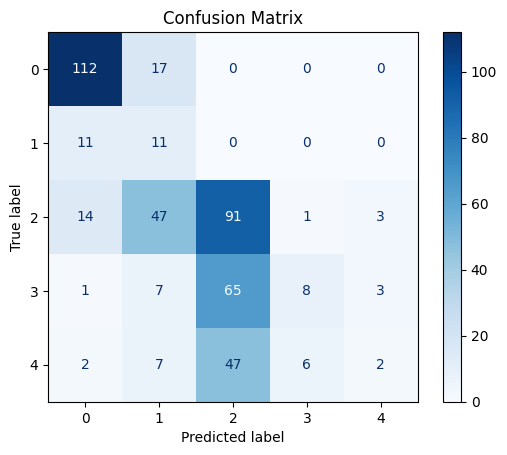

In [18]:
IDRID_test_results = engine.test_step(model=model,
            dataloader=IDRID_dataloader,
            device=device)

per class precision: [0.82486357 0.10222489 0.4720876  0.2804878  0.22222222]
per class recall: [0.95583437 0.04518873 0.33456303 0.01894563 0.08291874]
per class f1_score: [0.8855325  0.06267281 0.39160214 0.03549383 0.12077295]
average scores >>> precision: 0.3803772170514662 | recall: 0.28749010044400525 | f1_score: 0.2992148454970796
accuracy: 0.7598551590264297
QWK:  0.5082854758411111


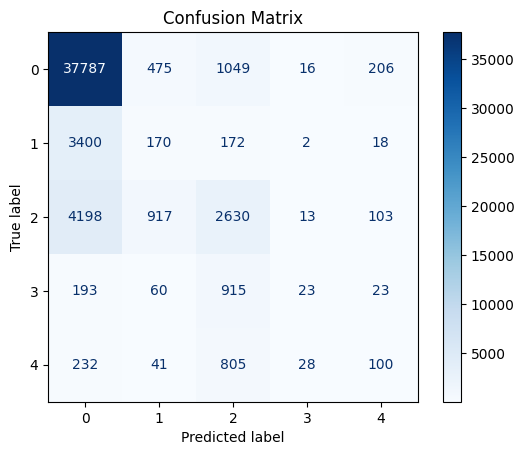

In [19]:
APTOS_15_test_results = engine.test_step(model=model,
            dataloader=APTOS_15_test_dataloader,
            device=device)

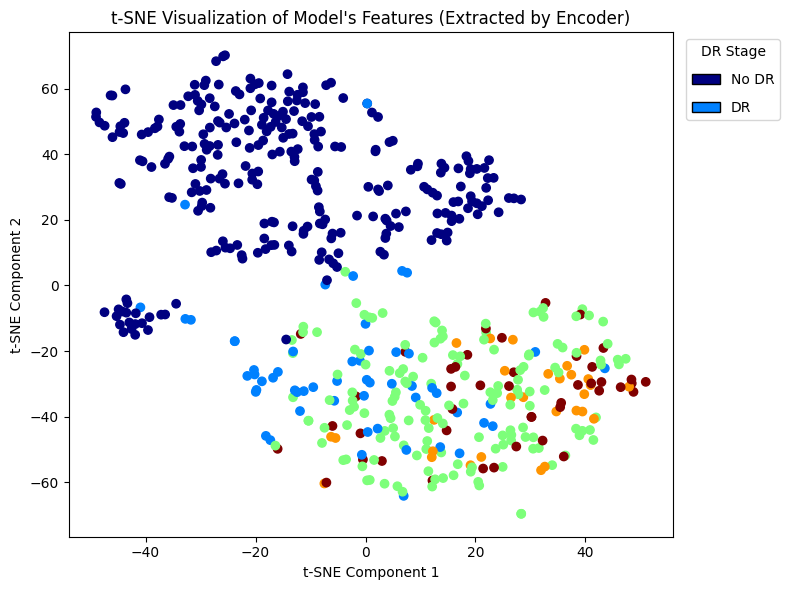

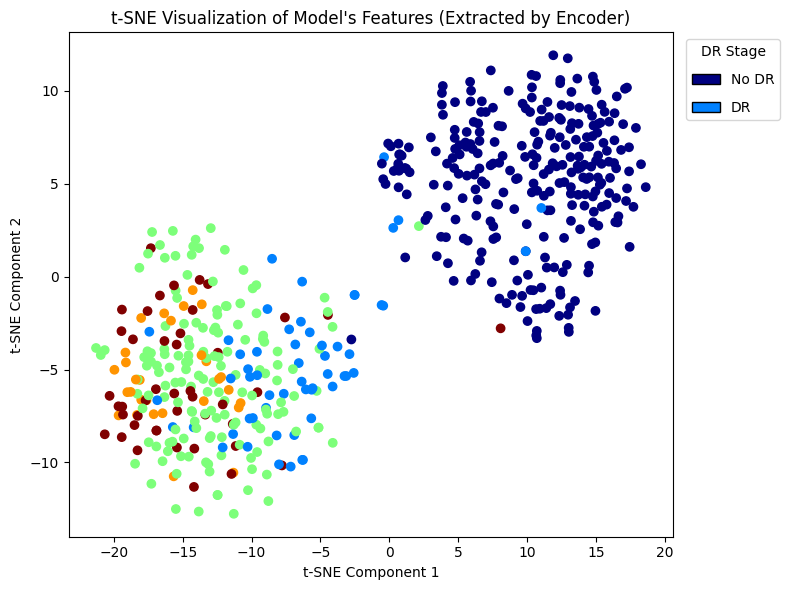

In [20]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=test_dataloader,
                        perp_vals=[5, 40],
                        NUM_ITER=2000)